In [2]:
# Imports
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Load the main dataset
case_study_df = pd.read_excel('/Users/lanahuyen/UCB Bootcamp/food_delivery/data/Food Delivery Time Prediction Case Study 2.xlsx')


In [3]:
# Calculate distance in kilometers using the Haversine formula
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in kilometers
    d_lat = np.radians(lat2 - lat1)
    d_lon = np.radians(lon2 - lon1)
    a = np.sin(d_lat / 2)**2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(d_lon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

# Apply the Haversine formula to calculate 'distance_km' and add it as a new column
case_study_df['distance_km'] = case_study_df.apply(lambda row: haversine(
    row['Restaurant_latitude'], row['Restaurant_longitude'],
    row['Delivery_location_latitude'], row['Delivery_location_longitude']), axis=1)

# One-hot encode categorical columns for 'Type_of_order' and 'Type_of_vehicle'
case_study_df = pd.get_dummies(case_study_df, columns=['Type_of_order', 'Type_of_vehicle'], drop_first=True)


In [4]:
# Apply holiday data using Calendarific API
API_KEY_CALENDARIFIC = 'WcjTgzLuGcVjeZitkgVRhSEyLW3xjmBx'
holiday_cache = {}

def fetch_holiday_data(date, country='US'):
    if date in holiday_cache:
        return holiday_cache[date]
    
    url = f"https://calendarific.com/api/v2/holidays?api_key={API_KEY_CALENDARIFIC}&country={country}&year={date.year}&month={date.month}&day={date.day}"
    response = requests.get(url)
    if response.status_code == 200:
        holidays = response.json().get('response', {}).get('holidays', [])
        is_holiday = 1 if holidays else 0
        holiday_cache[date] = is_holiday
        return is_holiday
    holiday_cache[date] = 0
    return 0

In [5]:
# Convert 'Time_taken(min)' to datetime if it represents a date, then apply holiday function
case_study_df['is_holiday'] = case_study_df['Time_taken(min)'].apply(lambda x: fetch_holiday_data(pd.to_datetime(x)))


In [6]:
# Restaurant density data using Yelp API with a small subset of unique locations
API_KEY_YELP = 'n4DmA-bIdakaxHcMcj8Ubxb4LN297nn1awkjjeDCFsLhQJHMX3G4aws_OUVNJQTp7Mc6kaqePbIxG0LCWPh7KpGCNZpJM6RTjyahWI_eJe21xugWrAXtW7qwQ00pZ3Yx'
HEADERS_YELP = {'Authorization': f'Bearer {API_KEY_YELP}'}
DEFAULT_DENSITY = 5
DEFAULT_AVG_RATING = 4.0
DEFAULT_TOTAL_REVIEWS = 20

In [7]:
# Round latitude and longitude to group locations
case_study_df['rounded_lat'] = case_study_df['Delivery_location_latitude'].round(2)
case_study_df['rounded_lon'] = case_study_df['Delivery_location_longitude'].round(2)


In [8]:
# Create unique locations and sample a subset
unique_locations = case_study_df[['rounded_lat', 'rounded_lon']].drop_duplicates().sample(n=10, random_state=1)
restaurant_cache = {}

def fetch_restaurant_density(lat, lon, radius=500):
    if (lat, lon) in restaurant_cache:
        return restaurant_cache[(lat, lon)]
    
    url = f"https://api.yelp.com/v3/businesses/search?latitude={lat}&longitude={lon}&radius={radius}&categories=restaurants&limit=10"
    response = requests.get(url, headers=HEADERS_YELP)
    if response.status_code == 200:
        businesses = response.json().get('businesses', [])
        ratings = [business['rating'] for business in businesses]
        num_reviews = [business['review_count'] for business in businesses]
        data = {
            'restaurant_density': len(businesses),
            'average_rating': sum(ratings) / len(ratings) if ratings else DEFAULT_AVG_RATING,
            'total_reviews': sum(num_reviews) if num_reviews else DEFAULT_TOTAL_REVIEWS
        }
        restaurant_cache[(lat, lon)] = data
        return data
    return {'restaurant_density': DEFAULT_DENSITY, 'average_rating': DEFAULT_AVG_RATING, 'total_reviews': DEFAULT_TOTAL_REVIEWS}


In [9]:
# Apply restaurant data function to sampled locations
for _, row in unique_locations.iterrows():
    lat, lon = row['rounded_lat'], row['rounded_lon']
    restaurant_cache[(lat, lon)] = fetch_restaurant_density(lat, lon)


In [10]:
# Map restaurant data to all rows
case_study_df['restaurant_data'] = case_study_df.apply(
    lambda row: restaurant_cache.get((row['rounded_lat'], row['rounded_lon']), {'restaurant_density': DEFAULT_DENSITY, 'average_rating': DEFAULT_AVG_RATING, 'total_reviews': DEFAULT_TOTAL_REVIEWS}), axis=1
)

# Split restaurant data into separate columns
restaurant_df = pd.DataFrame(case_study_df['restaurant_data'].tolist())
case_study_df = pd.concat([case_study_df, restaurant_df], axis=1)
case_study_df.drop(columns=['restaurant_data', 'rounded_lat', 'rounded_lon'], inplace=True)

# Save enhanced dataset for future use
case_study_df.to_csv('/Users/lanahuyen/UCB Bootcamp/food_delivery/data/enhanced_case_study.csv', index=False)

In [12]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the enhanced dataset with pre-calculated 'distance_km'
enhanced_case_study = pd.read_csv('/Users/lanahuyen/UCB Bootcamp/food_delivery/data/enhanced_case_study.csv')

# Verify the loaded data and confirm 'distance_km' exists
print("Enhanced Dataset Preview:\n", enhanced_case_study.head())

Enhanced Dataset Preview:
      ID Delivery_person_ID  Delivery_person_Age  Delivery_person_Ratings  \
0  4607     INDORES13DEL02                   37                      4.9   
1  B379     BANGRES18DEL02                   34                      4.5   
2  5D6D     BANGRES19DEL01                   23                      4.4   
3  7A6A    COIMBRES13DEL02                   38                      4.7   
4  70A2     CHENRES12DEL01                   32                      4.6   

   Restaurant_latitude  Restaurant_longitude  Delivery_location_latitude  \
0            22.745049             75.892471                   22.765049   
1            12.913041             77.683237                   13.043041   
2            12.914264             77.678400                   12.924264   
3            11.003669             76.976494                   11.053669   
4            12.972793             80.249982                   13.012793   

   Delivery_location_longitude  Time_taken(min)  distance_k

In [16]:
# Filter the dataset for realistic delivery distances (e.g., under 100 km)
filtered_data = enhanced_case_study[enhanced_case_study['distance_km'] <= 100]

# Verify the filtered data to confirm changes
print("Filtered Distance (km) Column Summary:\n", filtered_data['distance_km'].describe())

Filtered Distance (km) Column Summary:
 count    45162.000000
mean         9.735396
std          5.608508
min          1.465067
25%          4.663412
50%          9.220209
75%         13.681490
max         20.969489
Name: distance_km, dtype: float64


In [28]:
# Reload the enhanced dataset to ensure it's the correct one

enhanced_case_study = pd.read_csv('/Users/lanahuyen/UCB Bootcamp/food_delivery/data/enhanced_case_study.csv')

# Preview the data again to confirm it is the expected dataset
print("Enhanced Dataset Preview:\n", enhanced_case_study[['Time_taken(min)', 'distance_km']].head())


Enhanced Dataset Preview:
    Time_taken(min)  distance_km
0               24     3.025149
1               33    20.183530
2               26     1.552758
3               21     7.790401
4               30     6.210138


In [22]:
# Get a summary of the distance and time columns
print("\nSummary Statistics for Time and Distance:")
print(enhanced_case_study[['Time_taken(min)', 'distance_km']].describe())

# Check for any unusual values in the top rows by sorting
print("\nTop values in Distance:")
print(enhanced_case_study[['Time_taken(min)', 'distance_km']].sort_values(by='distance_km', ascending=False).head(10))

print("\nTop values in Time Taken:")
print(enhanced_case_study[['Time_taken(min)', 'distance_km']].sort_values(by='Time_taken(min)', ascending=False).head(10))



Summary Statistics for Time and Distance:
       Time_taken(min)   distance_km
count     45593.000000  45593.000000
mean         26.294607     99.303911
std           9.383806   1099.731281
min          10.000000      1.465067
25%          19.000000      4.663493
50%          26.000000      9.264281
75%          32.000000     13.763977
max          54.000000  19692.674606

Top values in Distance:
       Time_taken(min)   distance_km
33533               28  19692.674606
6788                46  19688.001288
2484                22  19683.687561
18826               15  19677.180552
9535                32  19070.408110
762                 15  19070.337839
35535               29  19069.158946
22291               44  19068.246962
30633               29  19067.128547
43454               21  19066.150742

Top values in Time Taken:
       Time_taken(min)   distance_km
5596                54     20.253459
43930               54     12.257491
13450               54      4.663439
38466            

In [29]:
# Check the data types
print("\nData Types of Columns:")
print(enhanced_case_study[['Time_taken(min)', 'distance_km']].dtypes)

# Ensure the columns are in numerical format for consistent plotting and calculations
enhanced_case_study['Time_taken(min)'] = pd.to_numeric(enhanced_case_study['Time_taken(min)'], errors='coerce')
enhanced_case_study['distance_km'] = pd.to_numeric(enhanced_case_study['distance_km'], errors='coerce')



Data Types of Columns:
Time_taken(min)      int64
distance_km        float64
dtype: object


In [20]:
# Check the data types
print("\nData Types of Columns:")
print(enhanced_case_study[['Time_taken(min)', 'distance_km']].dtypes)

# Ensure the columns are in numerical format for consistent plotting and calculations
enhanced_case_study['Time_taken(min)'] = pd.to_numeric(enhanced_case_study['Time_taken(min)'], errors='coerce')
enhanced_case_study['distance_km'] = pd.to_numeric(enhanced_case_study['distance_km'], errors='coerce')



Data Types of Columns:
Time_taken(min)      int64
distance_km        float64
dtype: object


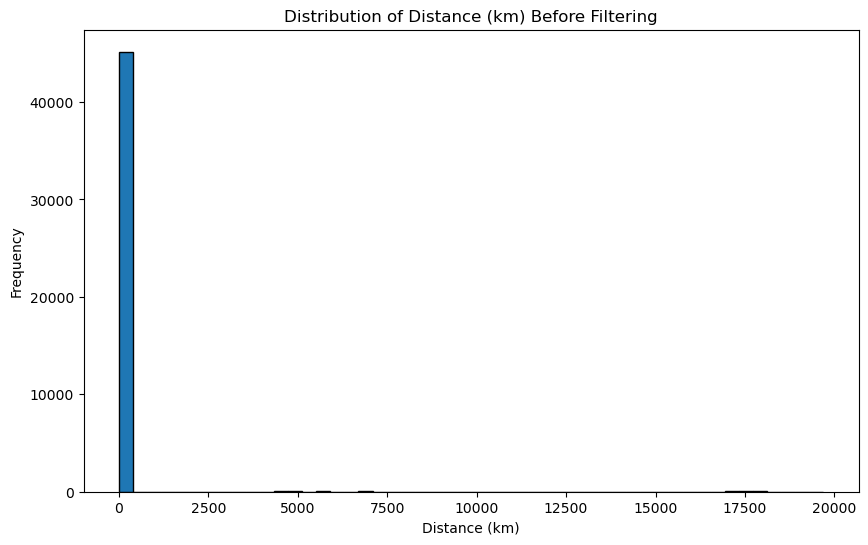

In [30]:
import matplotlib.pyplot as plt

# Histogram of distance values before filtering
plt.figure(figsize=(10, 6))
plt.hist(enhanced_case_study['distance_km'], bins=50, edgecolor='k')
plt.title('Distribution of Distance (km) Before Filtering')
plt.xlabel('Distance (km)')
plt.ylabel('Frequency')
plt.show()


In [33]:
# Filter the dataset for realistic delivery distances (e.g., 0 < distance_km <= 50)
filtered_data = enhanced_case_study[(enhanced_case_study['distance_km'] > 0) & (enhanced_case_study['distance_km'] <= 50)]

# Verify the filtered data to confirm zero distances are removed
print("Filtered Distance (km) Summary After Removing Zero Distances:\n", filtered_data['distance_km'].describe())


Filtered Distance (km) Summary After Removing Zero Distances:
 count    45162.000000
mean         9.735396
std          5.608508
min          1.465067
25%          4.663412
50%          9.220209
75%         13.681490
max         20.969489
Name: distance_km, dtype: float64


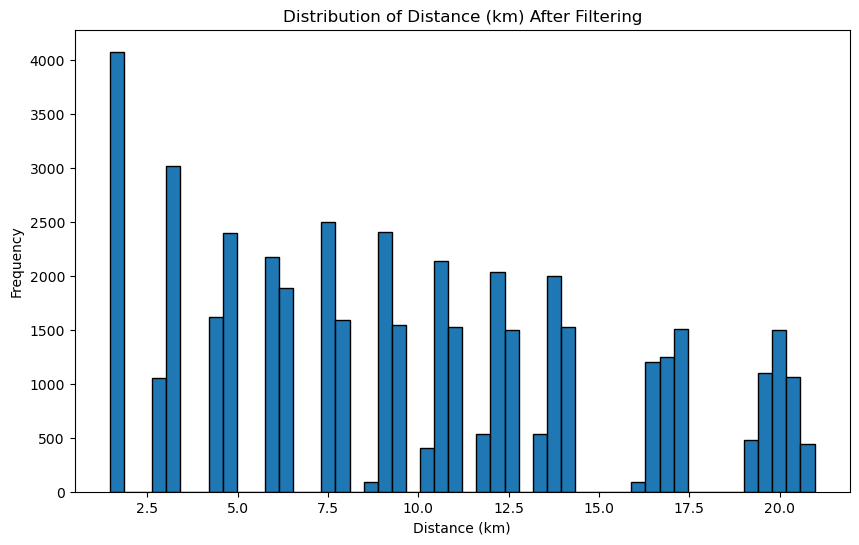

In [34]:
# Histogram of distance values after filtering
plt.figure(figsize=(10, 6))
plt.hist(filtered_data['distance_km'], bins=50, edgecolor='k')
plt.title('Distribution of Distance (km) After Filtering')
plt.xlabel('Distance (km)')
plt.ylabel('Frequency')
plt.show()


In [40]:
# Check columns to confirm the structure of the dataset
print("Columns in the dataset:", enhanced_case_study.columns)

Columns in the dataset: Index(['ID', 'Delivery_person_ID', 'Delivery_person_Age',
       'Delivery_person_Ratings', 'Restaurant_latitude',
       'Restaurant_longitude', 'Delivery_location_latitude',
       'Delivery_location_longitude', 'Time_taken(min)', 'distance_km',
       'Type_of_order_Drinks ', 'Type_of_order_Meal ', 'Type_of_order_Snack ',
       'Type_of_vehicle_electric_scooter ', 'Type_of_vehicle_motorcycle ',
       'Type_of_vehicle_scooter ', 'is_holiday', 'restaurant_density',
       'average_rating', 'total_reviews'],
      dtype='object')


In [43]:
# Ensure one-hot encoding for 'Type_of_order' if necessary
# If Type_of_order_* columns already exist, skip one-hot encoding
if not any(col.startswith('Type_of_order_') for col in enhanced_case_study.columns):
    enhanced_case_study = pd.get_dummies(enhanced_case_study, columns=['Type_of_order'], drop_first=True)

In [47]:
# Define the feature columns and target
features = ['distance_km', 'is_holiday', 'average_rating', 'restaurant_density', 'Delivery_person_Ratings',
            'Type_of_order_Drinks ', 'Type_of_order_Meal ', 'Type_of_order_Snack ']
target = 'Time_taken(min)'

In [46]:
# Check columns to confirm the structure of the dataset
print("Columns in the dataset:", enhanced_case_study.columns)

Columns in the dataset: Index(['ID', 'Delivery_person_ID', 'Delivery_person_Age',
       'Delivery_person_Ratings', 'Restaurant_latitude',
       'Restaurant_longitude', 'Delivery_location_latitude',
       'Delivery_location_longitude', 'Time_taken(min)', 'distance_km',
       'Type_of_order_Drinks ', 'Type_of_order_Meal ', 'Type_of_order_Snack ',
       'Type_of_vehicle_electric_scooter ', 'Type_of_vehicle_motorcycle ',
       'Type_of_vehicle_scooter ', 'is_holiday', 'restaurant_density',
       'average_rating', 'total_reviews'],
      dtype='object')


In [48]:
# Verify if selected features are in the DataFrame
missing_features = [feature for feature in features if feature not in enhanced_case_study.columns]
if missing_features:
    print(f"The following features are missing from the dataset: {missing_features}")
else:
    # Proceed with model training only if all features are present
    X = enhanced_case_study[features]
    y = enhanced_case_study[target]


In [50]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [57]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [58]:
# Initialize and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [59]:
# Make predictions on the test set
y_pred = model.predict(X_test)


In [60]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [62]:
print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 78.56912197128582
R-squared: 0.10389151842594935


In [63]:
coefficients = pd.DataFrame({'Feature': features, 'Coefficient': model.coef_})
print("\nFeature Coefficients:\n", coefficients)


Feature Coefficients:
                    Feature   Coefficient
0              distance_km -1.023281e-05
1               is_holiday  1.110223e-16
2           average_rating -4.440892e-16
3       restaurant_density -8.881784e-16
4  Delivery_person_Ratings -9.539632e+00
5    Type_of_order_Drinks  -1.745896e-01
6      Type_of_order_Meal   1.730118e-01
7     Type_of_order_Snack   3.082124e-02
